In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Layer
from sklearn.preprocessing import StandardScaler

2024-03-09 15:00:42.923374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 15:00:45.237800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pandas as pd
df=pd.read_csv('/home/behnaz/project-day-trading/combined-2024-02-09-2024-03-07.csv')
df.head()

,date,open,high,low,close
0,2024-02-09 00:00:00,1.07780,1.07790,1.07779,1.07780
1,2024-02-09 00:01:00,1.07780,1.07782,1.07775,1.07780
2,2024-02-09 00:02:00,1.07778,1.07786,1.07778,1.07785
3,2024-02-09 00:03:00,1.07784,1.07786,1.07778,1.07779
4,2024-02-09 00:04:00,1.07780,1.07780,1.07772,1.07773


In [3]:
df['return']=df['close'].diff()
df['date']=pd.to_datetime(df['date'])
df.dtypes

date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
return           float64
dtype: object

In [4]:
df['day']=df['date'].dt.day_of_week
df['hour']=df['date'].dt.hour
df.head()

,date,open,high,low,close,return,day,hour
0,2024-02-09 00:00:00,1.07780,1.07790,1.07779,1.07780,NaN,4,0
1,2024-02-09 00:01:00,1.07780,1.07782,1.07775,1.07780,0.00000,4,0
2,2024-02-09 00:02:00,1.07778,1.07786,1.07778,1.07785,0.00005,4,0
3,2024-02-09 00:03:00,1.07784,1.07786,1.07778,1.07779,-0.00006,4,0
4,2024-02-09 00:04:00,1.07780,1.07780,1.07772,1.07773,-0.00006,4,0


In [5]:
df['dir']=np.where(df['return']>0,1,0)
df.head()

,date,open,high,low,close,return,day,hour,dir
0,2024-02-09 00:00:00,1.07780,1.07790,1.07779,1.07780,NaN,4,0,0
1,2024-02-09 00:01:00,1.07780,1.07782,1.07775,1.07780,0.00000,4,0,0
2,2024-02-09 00:02:00,1.07778,1.07786,1.07778,1.07785,0.00005,4,0,1
3,2024-02-09 00:03:00,1.07784,1.07786,1.07778,1.07779,-0.00006,4,0,0
4,2024-02-09 00:04:00,1.07780,1.07780,1.07772,1.07773,-0.00006,4,0,0


In [6]:
timeframe=50
df['sma']=df['close'].rolling(timeframe).mean() - df['close'].rolling(150).mean()
df['min']=df['close'].rolling(timeframe).min()/df['close'] - 1
df['max']=df['close'].rolling(timeframe).max()/df['close'] - 1
df['mom']=df['close'].rolling(3).mean()
df['vola']=df['close'].rolling(timeframe).std()
df.tail()

,date,open,high,low,close,return,day,hour,dir,sma,min,max,mom,vola
28580,2024-03-07 23:56:00,1.09500,1.09501,1.09500,1.09500,0.00000,3,23,0,0.000147,-0.000146,0.000000,1.095000,0.000043
28581,2024-03-07 23:57:00,1.09500,1.09501,1.09500,1.09500,0.00000,3,23,0,0.000147,-0.000146,0.000000,1.095000,0.000042
28582,2024-03-07 23:58:00,1.09500,1.09506,1.09500,1.09503,0.00003,3,23,1,0.000148,-0.000174,0.000000,1.095010,0.000042
28583,2024-03-07 23:59:00,1.09502,1.09514,1.09502,1.09512,0.00009,3,23,1,0.000151,-0.000237,0.000000,1.095050,0.000044
28584,2024-03-08 00:00:00,1.09512,1.09514,1.09508,1.09510,-0.00002,4,0,0,0.000152,-0.000219,0.000018,1.095083,0.000046


In [7]:
#input_data= df[['day','hour','open','close','high','low','sma','min','max','mom', 'vola', 'dir']].values
input_data= df[['close','mom']]
targets=df['dir'].values
T=5
D=input_data.shape[1]
N=len(input_data)-T

In [8]:
Ntrain=int(len(input_data)*0.8)
Ntrain

22868

In [9]:
scaler=StandardScaler()
scaler.fit(input_data[:Ntrain+T])
input_data_scaled=scaler.transform(input_data)
input_data_scaled

array([[-0.45666609,         nan],
       [-0.45666609,         nan],
       [-0.44427339, -0.45256002],
       ...,
       [ 3.8138573 ,  3.8093921 ],
       [ 3.83616415,  3.81930746],
       [ 3.83120708,  3.82757026]])

In [10]:
X_train=np.zeros((Ntrain,T,D))
y_train=np.zeros(Ntrain)


In [11]:
for t in range(Ntrain):
    X_train[t, :, :]=input_data_scaled[t:t+T]
    y_train[t]=(targets[t+T])




In [12]:
X_test=np.zeros((N-Ntrain,T,D))
y_test=np.zeros(N-Ntrain)

for u in range(N- Ntrain):
    t= u + Ntrain
    X_test[u, :, :]=input_data[t:t+T]
    y_test[u]=(targets[t+T])
    
X_test.shape, y_test.shape

((5712, 5, 2), (5712,))

In [13]:
T = 5
D = input_data.shape[1]
model=Sequential()
model.add(LSTM(64, input_shape=(T, D)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

2024-03-09 15:00:48.397239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 15:00:48.398764: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/behnaz/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    loss='binary_crossentropy',
    optimizer= 'Adam',
    metrics=['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [17]:
#from tensorflow.keras.callbacks import EarlyStopping

#es = EarlyStopping(patience=5, restore_best_weights=True)
#callbacks=[es],

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size=32, 
                    epochs=10, 
                    verbose=1)

Epoch 1/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.5586 - loss: nan - val_accuracy: 0.5595 - val_loss: nan
Epoch 2/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5681 - loss: nan - val_accuracy: 0.5595 - val_loss: nan
Epoch 3/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5625 - loss: nan - val_accuracy: 0.5595 - val_loss: nan
Epoch 4/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5548 - loss: nan - val_accuracy: 0.5595 - val_loss: nan
Epoch 5/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5540 - loss: nan - val_accuracy: 0.5595 - val_loss: nan
Epoch 6/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5624 - loss: nan - val_accuracy: 0.5595 - val_loss: nan
Epoch 7/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5638 - loss: nan - val_accuracy: 0.5595 - val_loss: nan
Epoch 8/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5602 - loss: nan - val_accuracy: 0.5595 - val_loss: nan
Epoch 9/10
572/57

In [20]:
pred=model.predict(X_test)
pred

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [24]:
import matplotlib.pyplot as plt

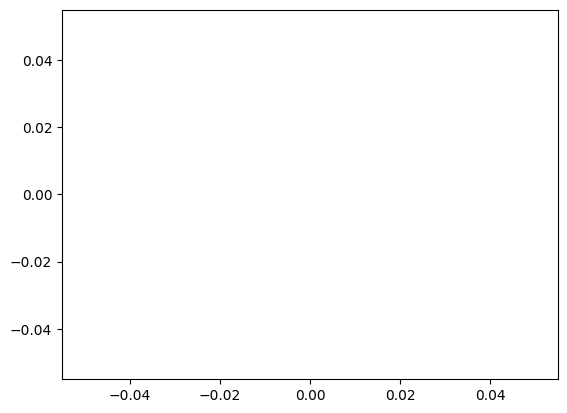

In [26]:
plt.scatter(y_test, pred)